In [5]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from timeit import default_timer as timer
from matplotlib.ticker import MaxNLocator
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count

# Using grid to generate different combinations of ec50_art and pmax_art

### Example 1: n = 500, 10 different values for ec50_art and pmax_art
### Other values set at default

In [6]:
# Setting min and max values for EC50 and pmax
min_ec50 = 0.1
max_ec50 = 0.2

min_pmax = 0.99997
max_pmax = 0.8

# Define the range for EC50 and pmax
ec50_values = np.linspace(min_ec50, max_ec50, 10)
pmax_values = np.linspace(min_pmax, max_pmax, 10)


In [7]:
# Create a meshgrid for all combinations
ec50_grid, pmax_grid = np.meshgrid(ec50_values, pmax_values)
efficacy_results = np.zeros(ec50_grid.shape)

# Flatten the grids for parallel processing
ec50_flat = ec50_grid.flatten()
pmax_flat = pmax_grid.flatten()

In [9]:
# Function to run a single simulation for a given (ec50, pmax) pair
def run_simulation(params):
    i, j, ec50, pmax = params

    command_ec50_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-o", "1",
        "-n", "500",
        "--pmax_art", str(pmax),
        "--ec50_art", str(ec50)
    ]

    try:
        # Run the command and capture output
        output_ec50_pmax_art_adj = subprocess.run(command_ec50_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_pmax_art_adj = output_ec50_pmax_art_adj.stdout.splitlines()
        df_ec50_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_ec50_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_ec50_pmax_art_adj = df_ec50_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the clearance rate
        failed_treatment_count = df_ec50_pmax_art_adj[(df_ec50_pmax_art_adj['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_ec50_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (i, j, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for EC50: {ec50}, pmax: {pmax}: {e}")
        return (i, j, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, j, ec50_flat[i * len(pmax_values) + j], pmax_flat[i * len(pmax_values) + j])
               for i in range(len(ec50_values)) for j in range(len(pmax_values))]

# Run simulations in parallel
with Pool(processes=num_workers) as pool:
    # Use tqdm to track the progress of the parallel tasks
    results = list(tqdm(pool.imap(run_simulation, params_list), total=len(params_list)))

# Update the clearance_rates grid with the results
for i, j, efficacy in results:
    efficacy_results[i, j] = efficacy

#Store results in a dataframe
df = pd.DataFrame(efficacy_results, index=ec50_values, columns=pmax_values)

#Save the resiults to a csv file
df.to_csv('pkpd_AL_pfcrt.K76_heatmaps_art.csv', index=True)

# Save the results to a pickle file
with open('pkpd_AL_pfcrt.K76_heatmaps_art.pyobj', 'wb') as f:
    pickle.dump(df, f)


100%|██████████| 100/100 [13:00<00:00,  7.81s/it] 


,0.999970,0.977751,0.955532,0.933313,0.911094,0.888876,0.866657,0.844438,0.822219,0.800000
0.100000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
0.111111,97.8,95.8,97.0,95.4,97.6,96.0,95.0,93.8,93.8,91.0
0.122222,94.0,93.8,91.4,91.4,92.0,91.8,91.8,91.0,91.0,91.0
0.133333,91.2,93.4,91.6,88.6,90.2,91.6,91.4,89.0,90.0,91.8
0.144444,92.2,91.6,89.6,91.4,89.8,90.8,89.2,90.6,90.0,90.0
0.155556,91.6,91.4,92.6,89.2,90.0,88.8,91.6,91.0,89.8,91.2
0.166667,88.6,91.4,91.0,88.6,88.8,92.2,89.6,88.0,90.8,92.0
0.177778,90.8,91.0,89.4,90.2,90.8,87.4,90.0,88.0,89.6,90.8
0.188889,89.0,90.6,89.8,90.4,89.4,90.4,91.2,89.8,89.8,89.8
0.200000,89.4,90.2,88.2,91.4,88.0,89.6,92.6,89.8,90.2,87.8


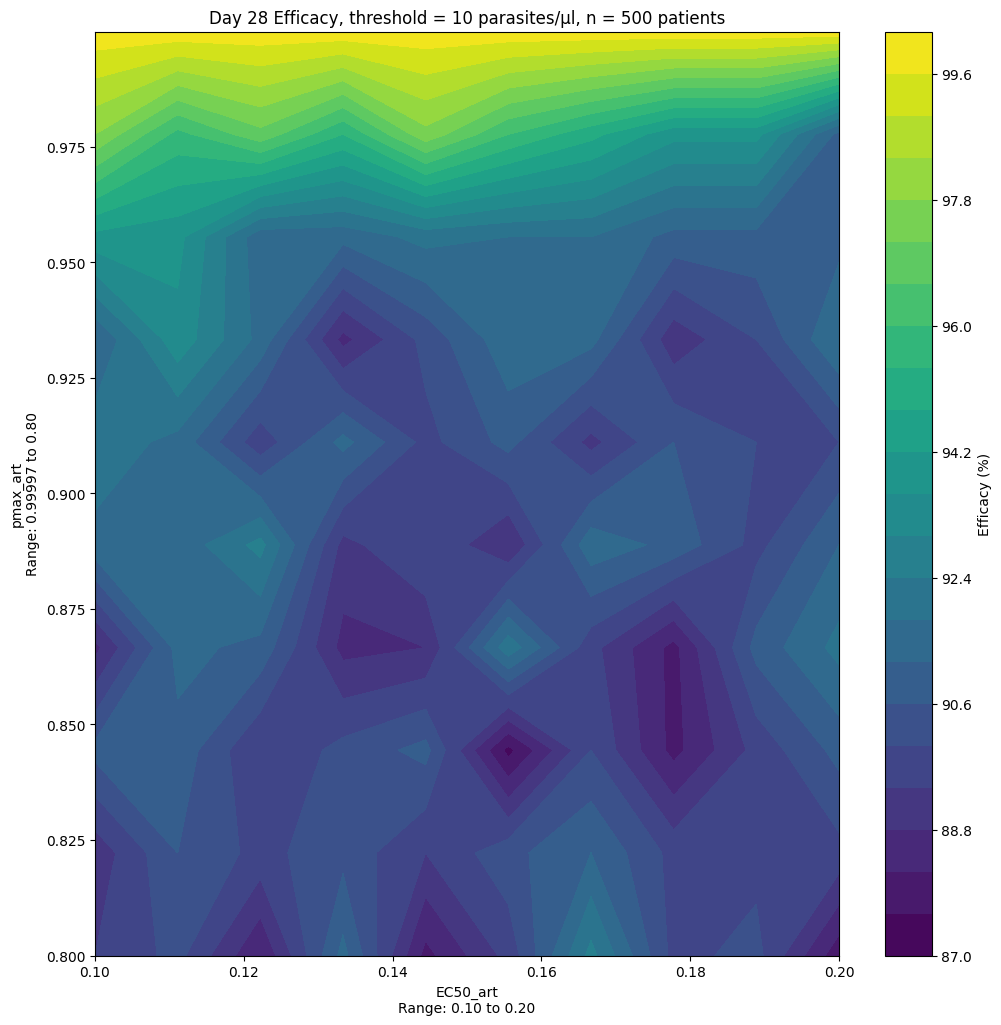

In [11]:
plt.figure(figsize=(12, 12))

plt.contourf(ec50_grid, pmax_grid, efficacy_results, levels=20, cmap='viridis')
plt.colorbar(label='Efficacy (%)')
plt.xlabel('EC50_art\nRange: {:.2f} to {:.2f}'.format(min_ec50, max_ec50))
plt.ylabel('pmax_art\nRange: {:.5f} to {:.2f}'.format(min_pmax, max_pmax))
plt.title('Day 28 Efficacy, threshold = 10 parasites/μl, n = 500 patients')
plt.show()

### Example 2: n = 500, 50 different values for ec50_art and pmax_art
### Other values set at default

In [12]:
# Setting min and max values for EC50 and pmax
min_ec50 = 0.1
max_ec50 = 0.2

min_pmax = 0.99997
max_pmax = 0.8

# Define the range for EC50 and pmax
ec50_values = np.linspace(min_ec50, max_ec50, 50)
pmax_values = np.linspace(min_pmax, max_pmax, 50)


In [13]:
# Create a meshgrid for all combinations
ec50_grid, pmax_grid = np.meshgrid(ec50_values, pmax_values)
efficacy_results = np.zeros(ec50_grid.shape)

# Flatten the grids for parallel processing
ec50_flat = ec50_grid.flatten()
pmax_flat = pmax_grid.flatten()

In [14]:
# Function to run a single simulation for a given (ec50, pmax) pair
def run_simulation(params):
    i, j, ec50, pmax = params

    command_ec50_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-o", "1",
        "-n", "500",
        "--pmax_art", str(pmax),
        "--ec50_art", str(ec50)
    ]

    try:
        # Run the command and capture output
        output_ec50_pmax_art_adj = subprocess.run(command_ec50_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_pmax_art_adj = output_ec50_pmax_art_adj.stdout.splitlines()
        df_ec50_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_ec50_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_ec50_pmax_art_adj = df_ec50_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the clearance rate
        failed_treatment_count = df_ec50_pmax_art_adj[(df_ec50_pmax_art_adj['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_ec50_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (i, j, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for EC50: {ec50}, pmax: {pmax}: {e}")
        return (i, j, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, j, ec50_flat[i * len(pmax_values) + j], pmax_flat[i * len(pmax_values) + j])
               for i in range(len(ec50_values)) for j in range(len(pmax_values))]

# Run simulations in parallel
with Pool(processes=num_workers) as pool:
    # Use tqdm to track the progress of the parallel tasks
    results = list(tqdm(pool.imap(run_simulation, params_list), total=len(params_list)))

# Update the clearance_rates grid with the results
for i, j, efficacy in results:
    efficacy_results[i, j] = efficacy

#Store results in a dataframe
df = pd.DataFrame(efficacy_results, index=ec50_values, columns=pmax_values)

#Save the resiults to a csv file
df.to_csv('pkpd_AL_pfcrt.K76_heatmaps_art.csv', index=True)

# Save the results to a pickle file
with open('pkpd_AL_pfcrt.K76_heatmaps_art.pyobj', 'wb') as f:
    pickle.dump(df, f)


100%|██████████| 2500/2500 [1:12:43<00:00,  1.75s/it]


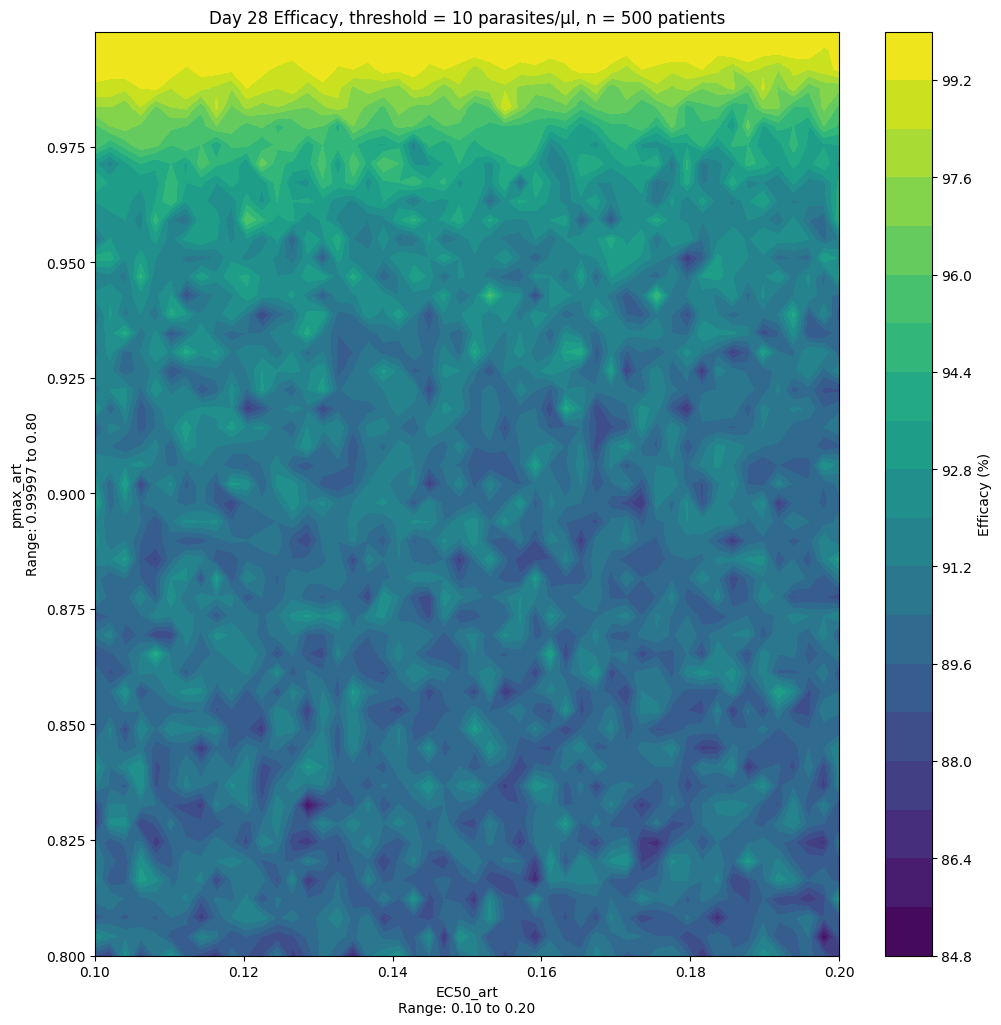

In [15]:
plt.figure(figsize=(12, 12))

plt.contourf(ec50_grid, pmax_grid, efficacy_results, levels=20, cmap='viridis')
plt.colorbar(label='Efficacy (%)')
plt.xlabel('EC50_art\nRange: {:.2f} to {:.2f}'.format(min_ec50, max_ec50))
plt.ylabel('pmax_art\nRange: {:.5f} to {:.2f}'.format(min_pmax, max_pmax))
plt.title('Day 28 Efficacy, threshold = 10 parasites/μl, n = 500 patients')
plt.show()

# Using grid to generate different combinations of ec50_art and pmax_art

### Example 3: n = 1000, 10 different values for ec50_art and pmax_art
### Other values set at default

In [19]:
# Setting min and max values for EC50 and pmax
min_ec50 = 0.1
max_ec50 = 0.2

min_pmax = 0.99997
max_pmax = 0.8

# Define the range for EC50 and pmax
ec50_values = np.linspace(min_ec50, max_ec50, 10)
pmax_values = np.linspace(min_pmax, max_pmax, 10)


In [20]:
# Create a meshgrid for all combinations
ec50_grid, pmax_grid = np.meshgrid(ec50_values, pmax_values)
efficacy_results = np.zeros(ec50_grid.shape)

# Flatten the grids for parallel processing
ec50_flat = ec50_grid.flatten()
pmax_flat = pmax_grid.flatten()

In [21]:
# Function to run a single simulation for a given (ec50, pmax) pair
def run_simulation(params):
    i, j, ec50, pmax = params

    command_ec50_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-o", "1",
        "-n", "1000",
        "--pmax_art", str(pmax),
        "--ec50_art", str(ec50)
    ]

    try:
        # Run the command and capture output
        output_ec50_pmax_art_adj = subprocess.run(command_ec50_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_pmax_art_adj = output_ec50_pmax_art_adj.stdout.splitlines()
        df_ec50_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_ec50_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_ec50_pmax_art_adj = df_ec50_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the clearance rate
        failed_treatment_count = df_ec50_pmax_art_adj[(df_ec50_pmax_art_adj['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_ec50_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (i, j, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for EC50: {ec50}, pmax: {pmax}: {e}")
        return (i, j, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, j, ec50_flat[i * len(pmax_values) + j], pmax_flat[i * len(pmax_values) + j])
               for i in range(len(ec50_values)) for j in range(len(pmax_values))]

# Run simulations in parallel
with Pool(processes=num_workers) as pool:
    # Use tqdm to track the progress of the parallel tasks
    results = list(tqdm(pool.imap(run_simulation, params_list), total=len(params_list)))

# Update the clearance_rates grid with the results
for i, j, efficacy in results:
    efficacy_results[i, j] = efficacy

#Store results in a dataframe
df = pd.DataFrame(efficacy_results, index=ec50_values, columns=pmax_values)

#Save the resiults to a csv file
df.to_csv('pkpd_AL_pfcrt.K76_heatmaps_art_1k.csv', index=True)

# Save the results to a pickle file
with open('pkpd_AL_pfcrt.K76_heatmaps_art_1k.pyobj', 'wb') as f:
    pickle.dump(df, f)


100%|██████████| 100/100 [06:12<00:00,  3.73s/it] 


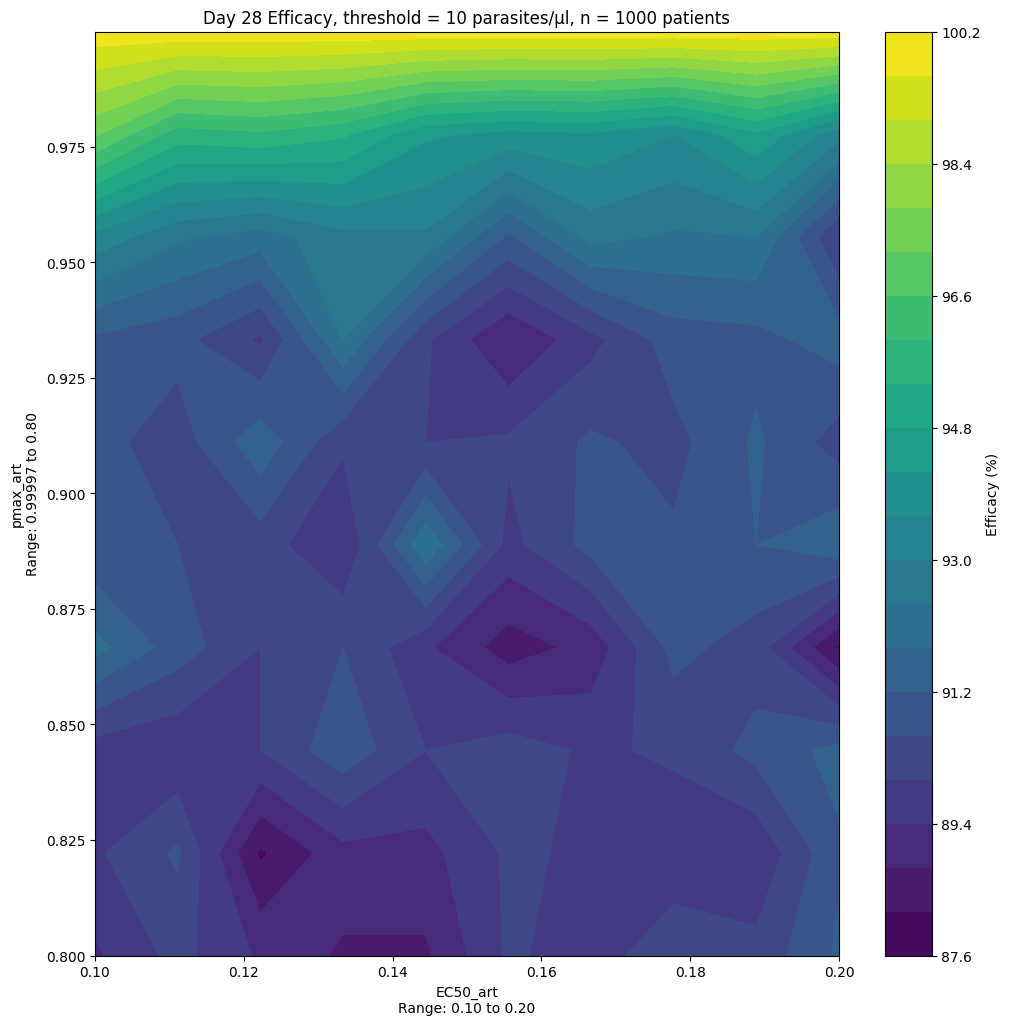

In [22]:
plt.figure(figsize=(12, 12))

plt.contourf(ec50_grid, pmax_grid, efficacy_results, levels=20, cmap='viridis')
plt.colorbar(label='Efficacy (%)')
plt.xlabel('EC50_art\nRange: {:.2f} to {:.2f}'.format(min_ec50, max_ec50))
plt.ylabel('pmax_art\nRange: {:.5f} to {:.2f}'.format(min_pmax, max_pmax))
plt.title('Day 28 Efficacy, threshold = 10 parasites/μl, n = 1000 patients')
plt.show()